In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [12]:
df = pd.read_csv('./interactions.csv', header=0, sep='\t')

In [13]:
df.head()

,user_id,item_id,interaction_type,created_at
0,1974005,2668706,1,1444154047
1,2690450,405777,1,1445338496
2,2690450,1180447,1,1444806365
3,2690450,136219,1,1444894128
4,2690450,1981683,1,1444894156


In [14]:
df.sort_values(by=['user_id', 'created_at'], ascending=True, inplace=True)

In [15]:
len(df)

8826678

In [16]:
df.head()

,user_id,item_id,interaction_type,created_at
4350402,7,1006839,1,1440965193
4038426,9,1053485,1,1444899932
4038424,9,944146,1,1444901029
4038423,9,944146,3,1444921016
4038425,9,944146,1,1444921021


In [17]:
duplicate_idx_raw = df.duplicated(subset=['user_id', 'item_id',  'interaction_type'], keep=False)
duplicate_idx_raw = list(duplicate_idx_raw[duplicate_idx_raw].index)
duplicate_idx_raw.sort()

In [19]:
duplicate_idx_raw[-1], len(duplicate_idx_raw)

(8826674, 2239898)

In [20]:
duplicate_idx = set()
for i in range(1, len(duplicate_idx_raw)):
    cur = df.iloc[duplicate_idx_raw[i]] 
    last = df.iloc[duplicate_idx_raw[i-1]] 
        
#     if cur.user_id == last.user_id and cur.item_id == last.item_id:
#         if cur.interaction_type - last.interaction_type < 10:
    if cur.user_id == last.user_id and cur.item_id == last.item_id and cur.interaction_type == last.interaction_type:
        if cur.created_at - last.created_at < 10:
            duplicate_idx.add(duplicate_idx_raw[i])
            duplicate_idx.add(duplicate_idx_raw[i-1])


In [21]:
print(len(duplicate_idx))

23576


In [35]:
print(len(duplicate_idx)) ### previous

289597


In [22]:
df.drop( duplicate_idx, inplace=True)

In [23]:
df.drop( df[ df.interaction_type == 4 ].index, inplace=True)

In [24]:
df.head()

,user_id,item_id,interaction_type,created_at
4350402,7,1006839,1,1440965193
4038426,9,1053485,1,1444899932
4038424,9,944146,1,1444901029
4038423,9,944146,3,1444921016
4038425,9,944146,1,1444921021


In [25]:
len(df) 

7787679

In [40]:
len(df) ### previous

7521658

In [26]:
# item filter
item_pop = df.item_id.value_counts()
good_items = item_pop[item_pop >= 50].index
df = df[df.item_id.isin(good_items)]

In [27]:
len(df) 

2676525

In [42]:
len(df) ### previous

2507241

In [28]:
# user filter
user_pop = df.user_id.value_counts()
good_user = user_pop[ (user_pop >= 10) & (user_pop <= 1000) ].index
df = df[df.user_id.isin(good_user)]

In [29]:
len(df), len(df.user_id.unique()), len(df.item_id.unique())

(1438380, 64891, 20667)

In [44]:
len(df), len(df.user_id.unique()), len(df.item_id.unique()) ### previous

(1287685, 60054, 19554)

In [30]:
good_user_index = df.user_id.unique()
np.random.shuffle(good_user_index ) 

In [31]:
train_size = int(len(good_user_index)*0.8)
test_size = int(len(good_user_index)*0.1)

train_user = good_user_index[ : train_size]
test_user= good_user_index[ train_size: train_size+test_size]
valid_user = good_user_index[ train_size+test_size : ]


In [32]:
items = df[df.user_id.isin(train_user)].item_id.unique()

In [33]:
len(items)

20662

In [48]:
len(items) ### previous

19552

In [34]:
df = df[df.item_id.isin(items)]

In [35]:
item_map = {}
idx = 1
for index, row in df.iterrows():
    item_id = row['item_id']
    if item_id not in item_map:
        item_map[item_id] = idx
        idx += 1
    row['item_id'] = item_map[item_id]
    

In [36]:
len(item_map), df.item_id.unique()

(20662, array([    1,     2,     3, ..., 20660, 20661, 20662]))

In [37]:
len(df) 

1438096

In [38]:
df.user_id.nunique(), len(df) / df.user_id.nunique(), len(df)/ df.item_id.nunique()

(64890, 22.162058868854984, 69.6010066789275)

In [48]:
print( df.user_id.value_counts().mean(), df.user_id.value_counts().std() )
print( df.item_id.value_counts().mean(), df.item_id.value_counts().std()  )
# freq = []
# for user in df.user_id.unique():
#     freq.append( len(df[user_id = user] ) )
# print( np.mean(freq), np.std(freq) )

22.162058868854984 21.248289399747794
69.6010066789275 112.63461992687843


In [51]:
len(item_map), df.item_id.unique() ### previous

(19552, array([    1,     2,     3, ..., 19550, 19551, 19552]))

In [52]:
len(df) ### previous

1287679

In [53]:
df.user_id.nunique(), len(df) / df.user_id.nunique(), len(df)/ df.item_id.nunique()

(60054, 21.442018849701935, 65.85919599018003)

In [39]:
t_list_train = []
y_list_train = []
t_list_test = []
y_list_test = []
t_list_valid = []
y_list_valid = []


for user in df.user_id.unique():
    user_seq = df.loc[df.user_id==user]
    if user in train_user:
        t_list = t_list_train
        y_list = y_list_train
    elif user in valid_user:
        t_list = t_list_valid
        y_list = y_list_valid
    elif user in test_user:
        t_list = t_list_test
        y_list = y_list_test
    else:
        print('error')
    t_list.append(user_seq['created_at'].values)
    y_list.append(user_seq['item_id'].values)
        

In [40]:
pickle.dump(t_list_train, open('./standardV2/train_time.pickle', 'wb') )
pickle.dump(y_list_train, open('./standardV2/train_item.pickle', 'wb') )
pickle.dump(t_list_test, open('./standardV2/test_time.pickle', 'wb') )
pickle.dump(y_list_test, open('./standardV2/test_item.pickle', 'wb') )
pickle.dump(t_list_valid, open('./standardV2/valid_time.pickle', 'wb') )
pickle.dump(y_list_valid, open('./standardV2/valid_item.pickle', 'wb') )

In [ ]:
t_list_train = []
y_list_train = []
t_list_test = []
y_list_test = []
t_list_valid = []
y_list_valid = []

cnt1 = 0
cnt2 = 0
cnt3 = 0
hist1 = []
hist2 = []
for user in df.user_id.unique():
    user_seq = df.loc[df.user_id==user]
    if user in train_user:
        t_list = t_list_train
        y_list = y_list_train
    elif user in valid_user:
        t_list = t_list_valid
        y_list = y_list_valid
    elif user in test_user:
        t_list = t_list_test
        y_list = y_list_test
    else:
        print('error')
    

    t = user_seq['created_at'].values
    y = user_seq['item_id'].values
    t_list_sub = [t[0] ]
    y_list_sub = [y[0] ]
    for i in range(1, len(user_seq)):
        hist2.append(t[i]-t[i-1])
        if y[i] == y[i-1]:
            hist1.append(t[i]-t[i-1])
#             if t[i]-t[i-1] < 10:
#                 cnt1 += 1
#             else:
#                 cnt2 += 1
        else:
            cnt3 += 1
            t_list_sub.append(t[i])
            y_list_sub.append(y[i])
        
        
    t_list.append(np.asarray(t_list_sub))
    y_list.append(np.asarray(y_list_sub))

In [ ]:
plt.hist( np.log10(np.asarray(hist1)+1) )

In [ ]:
plt.hist( np.log10(np.asarray(hist2)+1) )

In [ ]:
print(cnt1, cnt2, cnt3)

In [56]:
len(t_list_train), len(t_list_test), len(t_list_valid)


(48043, 6005, 6006)

In [57]:
len(y_list_train), len(y_list_test), len(y_list_valid)


(48043, 6005, 6006)

In [55]:
pickle.dump(t_list_train, open('./standard/train_time.pickle', 'wb') )
pickle.dump(y_list_train, open('./standard/train_item.pickle', 'wb') )
pickle.dump(t_list_test, open('./standard/test_time.pickle', 'wb') )
pickle.dump(y_list_test, open('./standard/test_item.pickle', 'wb') )
pickle.dump(t_list_valid, open('./standard/valid_time.pickle', 'wb') )
pickle.dump(y_list_valid, open('./standard/valid_item.pickle', 'wb') )



In [2]:
t_list_train = pickle.load(open('./standard/train_time.pickle', 'rb') )
y_list_train = pickle.load( open('./standard/train_item.pickle', 'rb') )
t_list_test = pickle.load( open('./standard/test_time.pickle', 'rb') )
y_list_test = pickle.load( open('./standard/test_item.pickle', 'rb') )
t_list_valid = pickle.load( open('./standard/valid_time.pickle', 'rb') )
y_list_valid = pickle.load( open('./standard/valid_item.pickle', 'rb') )

In [3]:
hist = []
for seq_index in range(len(t_list_train)):
    t_list = t_list_train[seq_index]
    for i in range(1, len(t_list)):
        diff = t_list[i]- t_list[i-1] 
        hist.append(diff)
        

(array([ 22284.,  39730.,  51718.,  72972., 106582., 132492., 118220.,
         75434.,  45480.,  27515.,  17729.,  13706.,  12981.,  13994.,
         13394.,  19886.,  55220.,  56335.,  68173.,  62272.,  39722.,
         13916.,   1231.]),
 array([      1,       2,       4,       8,      16,      32,      64,
            128,     256,     512,    1024,    2048,    4096,    8192,
          16384,   32768,   65536,  131072,  262144,  524288, 1048576,
        2097152, 4194304, 8388608]),
 <a list of 23 Patch objects>)

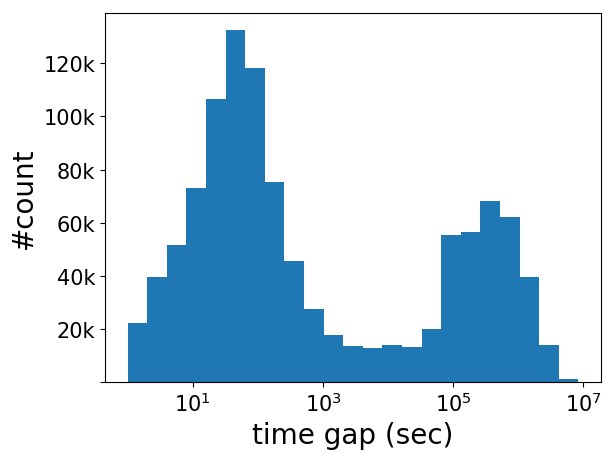

In [24]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif', serif='Times')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
# plt.rc('xlabel', labelsize=20)
# plt.rc('ylabel', labelsize=20)
plt.rc('axes', labelsize=20)
plt.yticks(np.arange(7)*20000, ('', '20k', '40k', '60k', '80k', '100k', '120k'))

bins = np.power( 2, np.arange(24) )
plt.xlabel('time gap (sec)')
plt.ylabel('#count')
plt.xscale('log')

plt.hist(hist,bins=bins)  

In [6]:
items = set()
for y in y_list_train:
    for yi in y:
        items.add(yi)


In [7]:
print( len(items) )

19552


In [9]:
print( len(y_list_train) + len(y_list_test) + len(t_list_valid))

60054


In [11]:
mint = 1440965193
maxt = 1440965193
for t in t_list_train:
    for ti in t:
        mint = min(ti,  mint)
        maxt = max(ti, maxt)
print(mint, maxt)

1439991506 1447023536
